In [1]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta

today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = (today - timedelta(days=365)).strftime("%Y-%m-%d")

# The 'Close' column is already adjusted
data = yf.download('GOOG',
                   start=start_date,
                   end=end_date,
                   progress=False)

data["Date"] = data.index
# Simply remove "Adj Close" from this list
data = data[["Date", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

print(data.tail())

/tmp/ipython-input-4293923185.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('GOOG',


Price        Date        Open        High         Low       Close    Volume
Ticker                   GOOG        GOOG        GOOG        GOOG      GOOG
245    2025-08-21  200.720001  203.360001  200.399994  200.619995  11768900
246    2025-08-22  203.960007  209.229996  202.130005  206.720001  25723700
247    2025-08-25  207.000000  211.089996  205.949997  209.160004  22788800
248    2025-08-26  208.369995  208.460007  206.449997  207.949997  23051000
249    2025-08-27  206.460007  209.570007  206.389999  208.210007  15232500


We only need the date and close prices columns for the rest of the task, so let’s select both the columns and move further:

In [2]:
# Let's assume 'data' is your two-column DataFrame with the MultiIndex
print("--- DataFrame Before reset_index() ---")
print(data.head())

# Reset the index to turn 'Price' and 'Ticker' into columns
data_cleaned = data.reset_index()

print("\n--- DataFrame After reset_index() ---")
print(data_cleaned.head())

--- DataFrame Before reset_index() ---
Price        Date        Open        High         Low       Close    Volume
Ticker                   GOOG        GOOG        GOOG        GOOG      GOOG
0      2024-08-28  165.983156  166.590242  162.499878  163.714050  15208700
1      2024-08-29  165.266588  166.829094  161.208069  162.619293  17133800
2      2024-08-30  163.435389  164.490322  162.629262  164.321136  18498800
3      2024-09-03  162.534710  162.599402  157.100791  157.852188  26533100
4      2024-09-04  157.319764  159.633652  156.687803  157.056030  17410700

--- DataFrame After reset_index() ---
Price  index       Date        Open        High         Low       Close  \
Ticker                         GOOG        GOOG        GOOG        GOOG   
0          0 2024-08-28  165.983156  166.590242  162.499878  163.714050   
1          1 2024-08-29  165.266588  166.829094  161.208069  162.619293   
2          2 2024-08-30  163.435389  164.490322  162.629262  164.321136   
3          3 20

Now let’s visualize the close prices of Google before moving forward:

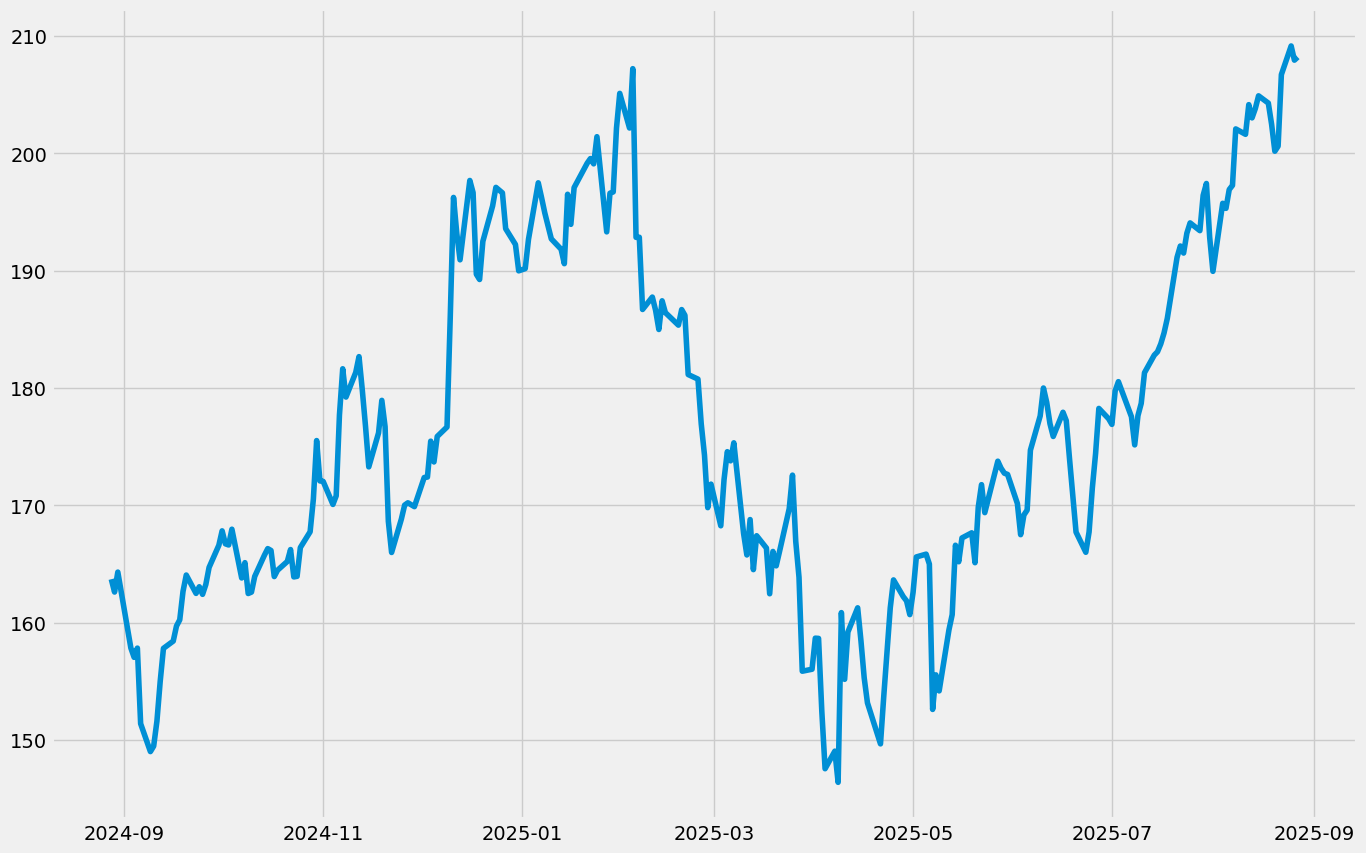

In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

<Figure size 640x480 with 0 Axes>

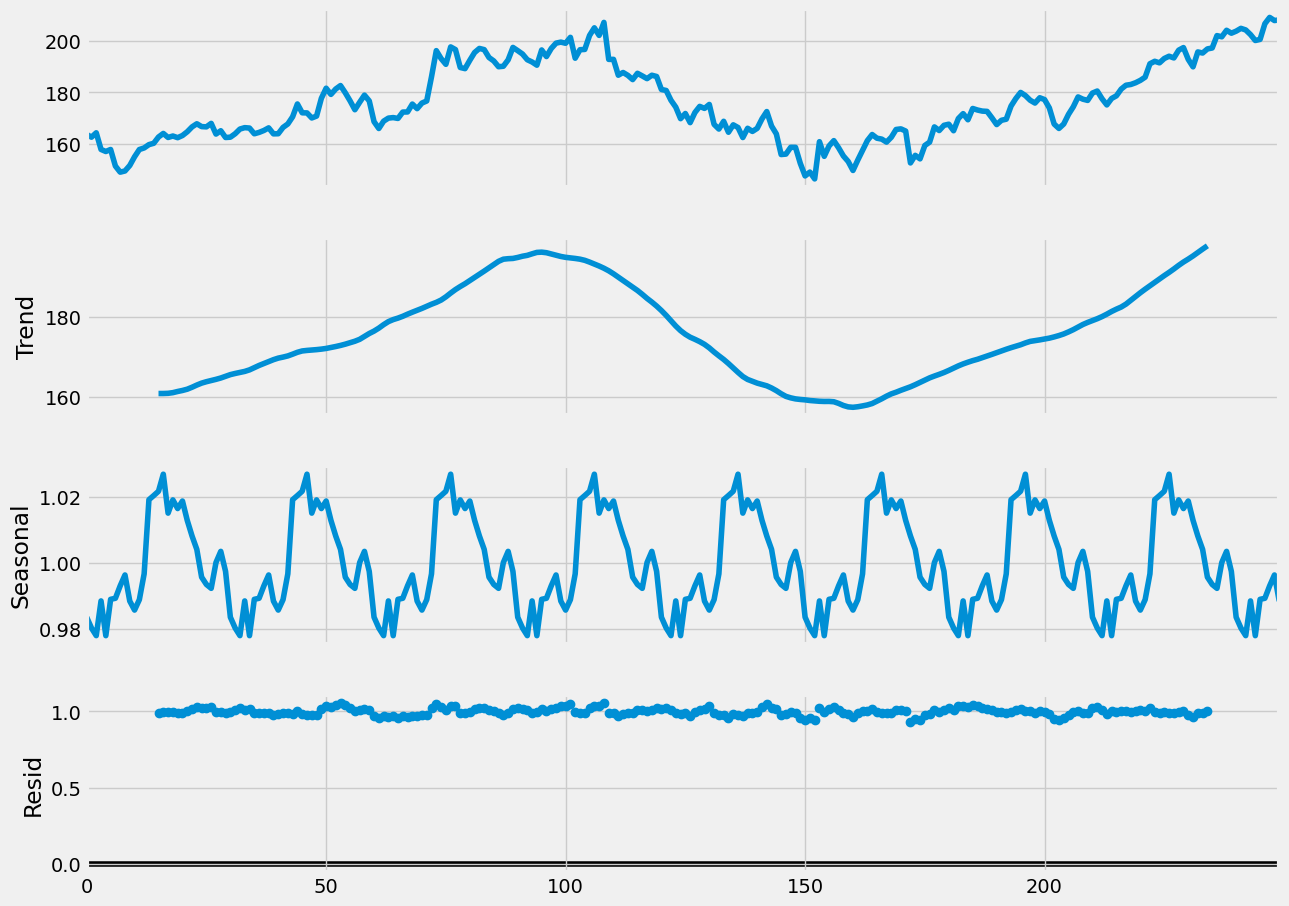

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"],
                            model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 10)

So our data is not stationary it is seasonal. We need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data. But before using the SARIMA model, we will use the ARIMA model. It will help you learn using both models.

To use ARIMA or SARIMA, we need to find the p, d, and q values. We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

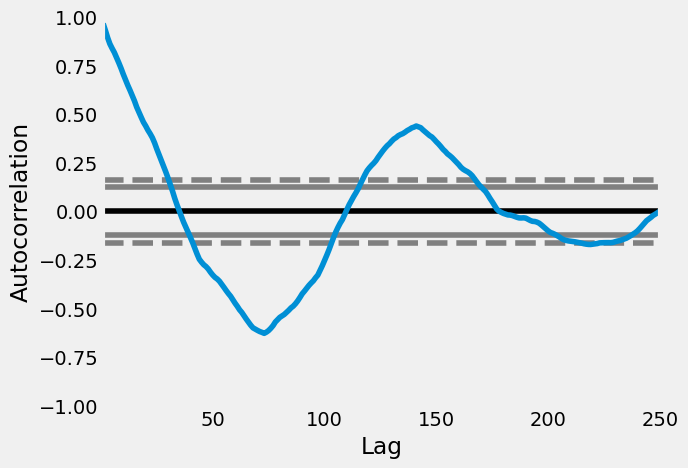

In [5]:
pd.plotting.autocorrelation_plot(data["Close"])

In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5. Now let’s find the value of q (moving average):

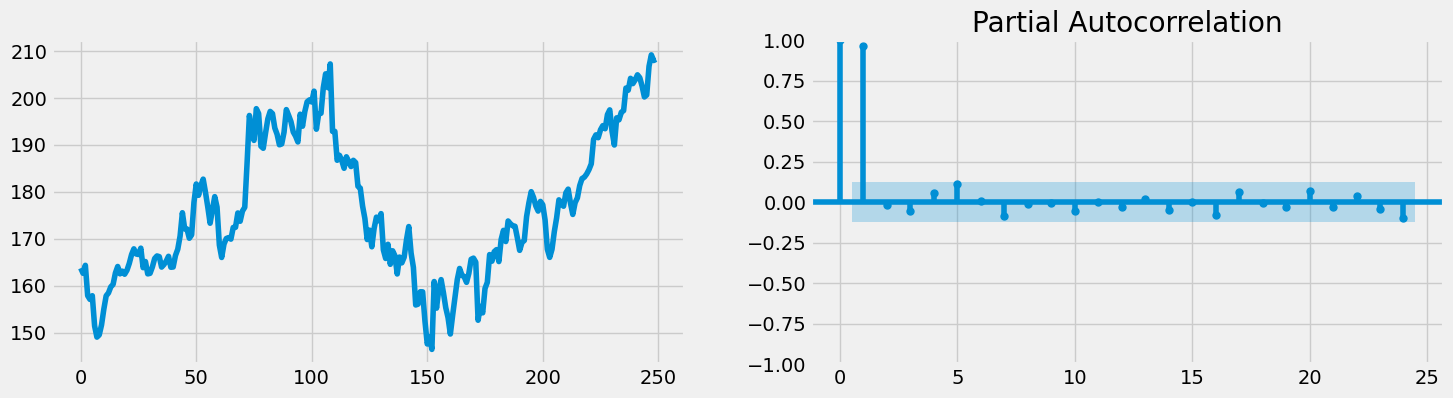

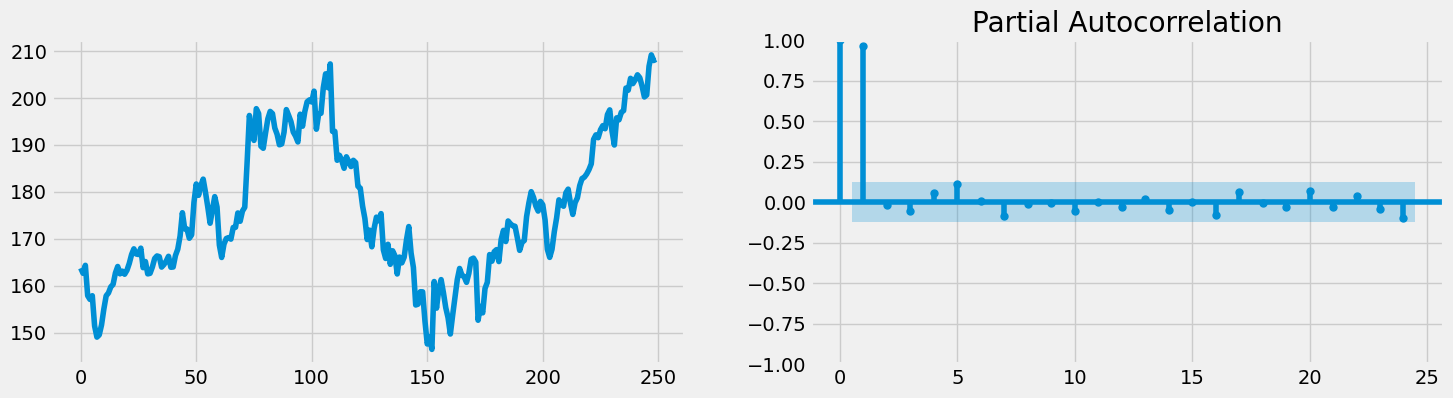

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(data['Close'])
plot_pacf(data["Close"],ax=ax2)

In [7]:
# Cell 1: Run this to install the correct libraries
!pip install pmdarima numpy==1.26.4

In [15]:
# Cell 2: Run this cell AFTER restarting
import yfinance as yf
from pmdarima.arima.utils import ndiffs
from datetime import date, timedelta
import warnings

# Ignore warnings for a cleaner output
warnings.filterwarnings('ignore')

# Define date range and download data
today = date.today()
start_date = today - timedelta(days=365)
data = yf.download('GOOG', start=start_date, end=end_date, progress=False)

# This will now work without error
d_order = ndiffs(data['Close'], test='adf')

print(f"The estimated order of differencing (d) is: {d_order}")

The estimated order of differencing (d) is: 1


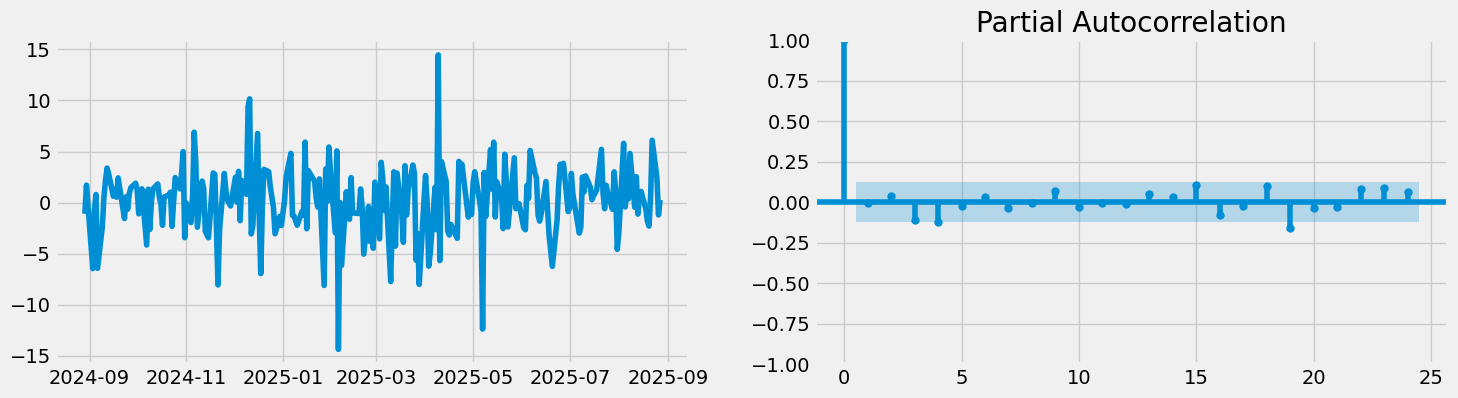

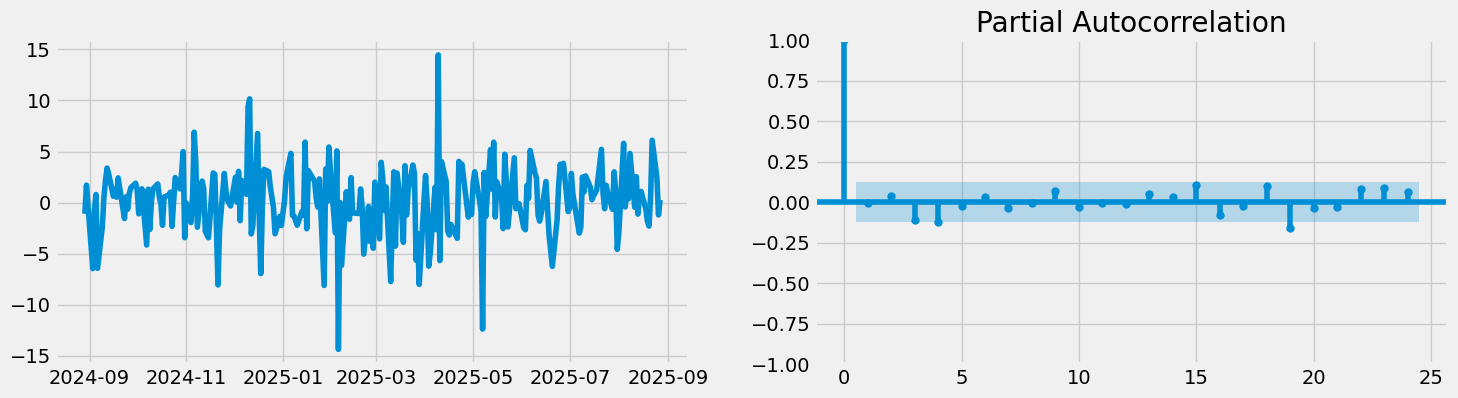

In [16]:
diff=data['Close'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
plot_pacf(diff,ax=ax2)

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. Hence the value of q is 2.
# ARIMA Model

In [17]:
p, d, q = 5, 1, 1
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Close"], order=(p,d,q))
# Fit the model
fitted = model.fit()
# Set the display option
fitted.params['disp'] = -1
# Print the summary
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                   GOOG   No. Observations:                  250
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -652.010
Date:                Thu, 28 Aug 2025   AIC                           1318.020
Time:                        09:34:09   BIC                           1342.642
Sample:                             0   HQIC                          1327.931
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4914      1.347     -0.365      0.715      -3.131       2.148
ar.L2          0.0360      0.074      0.489      0.625      -0.108       0.180
ar.L3         -0.0878      0.093     -0.940      0.3

In [18]:
predictions = fitted.predict()
print(predictions)

Date
2024-08-28      0.000000
2024-08-29    163.714041
2024-08-30    162.624894
2024-09-03    164.267338
2024-09-04    158.044509
                 ...    
2025-08-21    200.017887
2025-08-22    200.782299
2025-08-25    207.126435
2025-08-26    209.667700
2025-08-27    207.408431
Name: predicted_mean, Length: 250, dtype: float64


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model:

In [19]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               GOOG   No. Observations:                  250
Model:             SARIMAX(5, 1, 1)x(5, 1, 1, 12)   Log Likelihood                -637.564
Date:                            Thu, 28 Aug 2025   AIC                           1301.128
Time:                                    09:35:01   BIC                           1346.213
Sample:                                         0   HQIC                          1319.300
                                            - 250                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5495      2.061     -0.267      0.790      -4.589       3.490
ar.L2          0.0152      0.101   

Now let’s predict the future stock prices using the SARIMA model for the next 10 days:



In [20]:
predictions = model.predict(len(data), len(data)+30)
print(predictions)

250    208.158942
251    207.463966
252    208.574552
253    208.807307
254    208.126950
255    206.760618
256    207.325075
257    207.743959
258    207.735999
259    208.553366
260    209.846544
261    211.286155
262    212.655609
263    212.261707
264    212.594475
265    212.682764
266    212.200005
267    210.735655
268    210.406812
269    210.794771
270    210.882556
271    212.074876
272    212.932986
273    214.254155
274    214.516023
275    213.920956
276    214.122182
277    214.315144
278    214.286424
279    213.263265
280    212.779441
Name: predicted_mean, dtype: float64


Here’s how you can plot the predictions:



<Axes: xlabel='Date'>

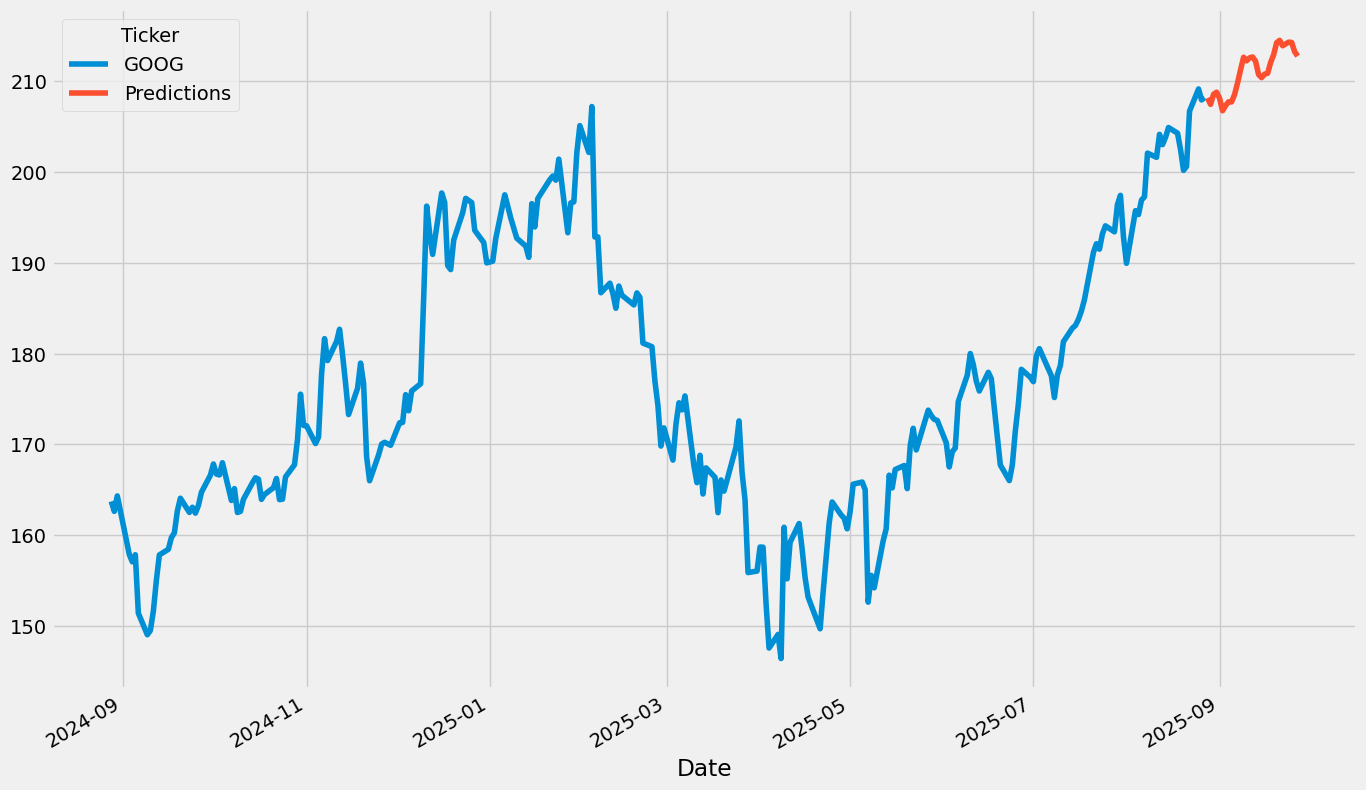

In [21]:
# Assume 'data' and 'predictions' already exist and pandas is imported as pd

# 1. Get the last date from your training data
last_date = data.index[-1]

# 2. Create a new date range for the predictions
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(predictions))

# 3. Set this new date range as the index for your predictions
predictions.index = prediction_dates

# 4. Plot the data and the corrected predictions
data["Close"].plot(legend=True, label="GOOG", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")